UCD PROJECT:  J Doyle

This aim of the project is 
(i)	to investigate the relationship between the take-up rate of Guaranteed Annuity Options (“GAO take-up Rate”) on a closed block of life insurance pension policies and the prevailing interest rates at the exercise dates of these options over the period 2007 to 2021.

(ii)	In the event of such a relationship being present and being statistically significant, develop  models based the historical experience of the block of policies for the valuation of the GAO options for remaining in-force policies which have not yet reached retirement.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm



In [2]:
# importing Interest Rate data from Excel

file = r'C:\A_Treasure\\UCD course 2021\Assignment\EuroSwapRates4.xlsx'
xls = pd.ExcelFile(file)
print(xls.sheet_names)
df = xls.parse('EuroSwapRates') # sheet name, as a string
df

['EuroSwapRates', 'Sheet1', 'Euro$ Swap']


,Date,2021-09-30 00:00:00,2021-08-31 00:00:00,2021-07-30 00:00:00,2021-06-30 00:00:00,2021-05-31 00:00:00,2021-04-30 00:00:00,2021-03-31 00:00:00,2021-02-26 00:00:00,2021-01-29 00:00:00,...,2009-06-30 00:00:00,2009-03-31 00:00:00,2008-12-31 00:00:00,2008-09-30 00:00:00,2008-06-30 00:00:00,2008-03-31 00:00:00,2007-12-31 00:00:00,2007-09-30 00:00:00,2007-06-30 00:00:00,2007-03-31 00:00:00
0,1D,-0.4870,-0.4830,-0.4860,-0.4830,-0.4810,-0.4840,-0.4850,-0.4810,-0.4790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1Y,-0.4880,-0.5010,-0.5020,-0.4830,-0.4830,-0.4810,-0.4940,-0.4830,-0.5120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2Y,-0.4290,-0.4810,-0.4960,-0.4585,-0.4700,-0.4788,-0.4973,-0.4643,-0.5394,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3Y,-0.3520,-0.4360,-0.4560,-0.3965,-0.4090,-0.4100,-0.4490,-0.4230,-0.5160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4Y,-0.2720,-0.3850,-0.4110,-0.3280,-0.3390,-0.3450,-0.3880,-0.3650,-0.4830,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5Y,-0.1940,-0.3320,-0.3630,-0.2540,-0.2620,-0.2640,-0.3090,-0.3090,-0.4410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6Y,-0.1180,-0.2750,-0.3080,-0.1800,-0.1820,-0.1820,-0.2310,-0.2420,-0.3935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7Y,-0.0450,-0.2140,-0.2520,-0.1070,-0.1030,-0.0970,-0.1510,-0.1730,-0.3450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8Y,0.0260,-0.1520,-0.1910,-0.0340,-0.0240,-0.0160,-0.0740,-0.1070,-0.2940,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9Y,0.0940,-0.0959,-0.1300,0.0370,0.0500,0.0620,0.0010,-0.0430,-0.2410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# May need array of Current interest rates for discounting and annuity calculations later
df_CurrRates=df[df.columns[0:2]]
df_CurrRates

,Date,2021-09-30 00:00:00
0,1D,-0.4870
1,1Y,-0.4880
2,2Y,-0.4290
3,3Y,-0.3520
4,4Y,-0.2720
5,5Y,-0.1940
6,6Y,-0.1180
7,7Y,-0.0450
8,8Y,0.0260
9,9Y,0.0940


In [4]:
# some tidy up of dataframe i.e. transpose for easier readability, make DateOfRate a column etc

df_R =df.set_index('Date').transpose().copy()
df_R.reset_index(inplace=True)
df_R.rename(columns={'index': 'DateOfRate'}, inplace=True)
df_R

Date,DateOfRate,1D,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,11Y,12Y,15Y,20Y,25Y,30Y,35Y,40Y
0,2021-09-30,-0.487,-0.488,-0.4290,-0.3520,-0.272,-0.194,-0.118,-0.045,0.026,0.0940,0.1609,0.217,0.2710,0.3990,0.5010,0.513,0.4826,0.451,0.415
1,2021-08-31,-0.483,-0.501,-0.4810,-0.4360,-0.385,-0.332,-0.275,-0.214,-0.152,-0.0959,-0.0267,0.028,0.0810,0.2110,0.3150,0.329,0.3029,0.269,0.236
2,2021-07-30,-0.486,-0.502,-0.4960,-0.4560,-0.411,-0.363,-0.308,-0.252,-0.191,-0.1300,-0.0725,-0.012,0.0425,0.1725,0.2765,0.289,0.2587,0.231,0.197
3,2021-06-30,-0.483,-0.483,-0.4585,-0.3965,-0.328,-0.254,-0.180,-0.107,-0.034,0.0370,0.1024,0.166,0.2240,0.3620,0.4770,0.498,0.4770,0.451,0.422
4,2021-05-31,-0.481,-0.483,-0.4700,-0.4090,-0.339,-0.262,-0.182,-0.103,-0.024,0.0500,0.1191,0.183,0.2410,0.3810,0.4970,0.521,0.5050,0.485,0.460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,2008-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.4100,NaN,NaN,4.6250,NaN,NaN,NaN,NaN,NaN
131,2007-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.7200,NaN,NaN,4.8590,NaN,NaN,NaN,NaN,NaN
132,2007-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.7030,NaN,NaN,4.8355,NaN,NaN,NaN,NaN,NaN
133,2007-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.8480,NaN,NaN,4.9320,NaN,NaN,NaN,NaN,NaN


In [5]:
#check to see if there are any null values, particularly for (i) 10Y and 15Y throughout period since 2007 
#Conclusion:  No nulls for 10Y and 15Y:  All good

df_R.isnull().sum()

Date
DateOfRate     0
1D            16
1Y            11
2Y            11
3Y            11
4Y            11
5Y            11
6Y            11
7Y            11
8Y            11
9Y            11
10Y            0
11Y           13
12Y           11
15Y            0
20Y           11
25Y           11
30Y           11
35Y           13
40Y           13
dtype: int64

In [6]:
# reducing data frame to key columns
df_R2=df_R[['DateOfRate', '10Y', '15Y']].copy()

# adding a column for Avg (10Y, 15Y) rate
df_R2['Avg_10_15']=df_R2[['10Y','15Y']].mean(axis=1)

# adding a column which groups Avg rates into bands of 25bps by putting a ceiling on Avg_10_15 in steps of 25bps.
# this will be used to see if this grouping reduces noise in the regressions

step = 0.25
df_R2['AvgC_10_15'] = np.ceil((df_R2['Avg_10_15'].values / step)) * step

# print df_R2 to check results
df_R2.head(20)


Date,DateOfRate,10Y,15Y,Avg_10_15,AvgC_10_15
0,2021-09-30,0.1609,0.3990,0.27995,0.50
1,2021-08-31,-0.0267,0.2110,0.09215,0.25
2,2021-07-30,-0.0725,0.1725,0.05000,0.25
3,2021-06-30,0.1024,0.3620,0.23220,0.25
4,2021-05-31,0.1191,0.3810,0.25005,0.50
5,2021-04-30,0.1360,0.4070,0.27150,0.50
6,2021-03-31,0.0670,0.3430,0.20500,0.25
7,2021-02-26,0.0460,0.2560,0.15100,0.25
8,2021-01-29,-0.1860,0.0225,-0.08175,-0.00
9,2020-12-31,-0.2604,-0.0820,-0.17120,-0.00


In [7]:
# Reinsurance contract incepted on 1 Jan 2007.
# I want to claculate Calendar Quarters since then for DateOfRate
# the following seems cumbersome (I wanted to take DateofRate.dt.year directly into the function at step 2 but kept getting errors) but it was the only way I could get it to work

#Step 1

# Add columns for Year and Month of DateofRate  
df_R2['Year']=df_R2['DateOfRate'].dt.year
df_R2['Month']=df_R2['DateOfRate'].dt.month


#step 2:  

#Function to calculate Contract Quarter using Year since 2007 and Month

def CQ_Rate(df):
    QY =df['Year']-2007
    QY = QY*4
    QQ =df['Month']
    if QQ/3== QQ//3:
        QQ = QQ//3
        Quarter = QY+QQ
    else:
        Quarter = 999 # setting non quarter-end months to 999 for later one-to-one joining with GAO TakeUpRats which are only claculated on a quarter-end basis.
   
    return Quarter
df_R2['Contract_Quarter'] = df_R2.apply(CQ_Rate, axis=1)

# Step 3

# dropping interest rates for non quarter ends i.e. where Contract_Quarter = 999

df_R3=df_R2[(df_R2['Contract_Quarter'] !=999)].copy()

# print df_R3 to check results
df_R3.head()

Date,DateOfRate,10Y,15Y,Avg_10_15,AvgC_10_15,Year,Month,Contract_Quarter
0,2021-09-30,0.1609,0.399,0.27995,0.50,2021,9,59
3,2021-06-30,0.1024,0.362,0.23220,0.25,2021,6,58
6,2021-03-31,0.0670,0.343,0.20500,0.25,2021,3,57
9,2020-12-31,-0.2604,-0.082,-0.17120,-0.00,2020,12,56
12,2020-09-30,-0.2291,-0.055,-0.14205,-0.00,2020,9,55


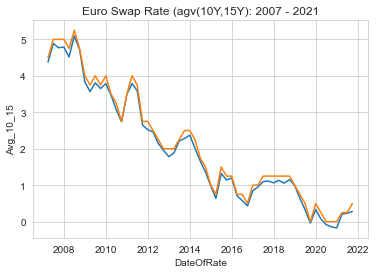

Correlation co-efficient between Avg_10_15 and AvgC_10_15 =  0.999


In [8]:
# Graph Avg_10_15 from 2007 - 2021.

# Conclusion 1:  Interest Rates 2007- 2021: overall fall in avg-10_15 euro swap rate from approx. 5%  in 2007/2008 to at//below/close to 0% since 2020 
# Conclusion 2:  Unsuprisingly, there is very high (99.9%) correelation between Avg_10_15 and AvgC_10_15.
                # Therefore, I'll use AvgC_10_15 in the remaining work

sns.set_style("whitegrid")
g= sns.lineplot(x=df_R3['DateOfRate'], y=df_R3['Avg_10_15'])
g.set_title("Euro Swap Rate (agv(10Y,15Y): 2007 - 2021")
sns.lineplot(x=df_R3['DateOfRate'], y=df_R3['AvgC_10_15'])
plt.show()
print('Correlation co-efficient between Avg_10_15 and AvgC_10_15 = ' , round(df_R3['Avg_10_15'].corr(df_R3['AvgC_10_15']),3))

In [9]:
# Importing Claim Data with historical exposure and claim information on a seriatim basis from Reinsurance Contract inception on 1 Jan 2017 until 30 Sept 2021.

# Claim information is provisded by insurance company on a quarterly basis

file1 = r'C:\A_Treasure\\UCD course 2021\Assignment\PolicyData_Project.xlsx'
xls = pd.ExcelFile(file1)
print(xls.sheet_names)
df = xls.parse('PolicyData') # sheet name, as a string
df.head()

['PolicyData']


,PolicyNumber,DateOfBirth,NRA,DateOfClaim,Contract_Quarter,Gender,ClaimType,Exposure,Claim,Product
0,1,1963-08-27,2028-08-27,2007-09-30,3,M,Surrender,55286.922010,0.0,OP_A
1,2,1954-03-31,2014-03-31,2007-09-30,3,M,Surrender,13765.046997,0.0,OP_A
2,3,1953-08-15,2013-08-15,2007-09-30,3,F,Surrender,5681.471942,0.0,OP_A
3,4,1960-04-26,2025-04-26,2007-09-30,3,M,Surrender,9321.834228,0.0,OP_A
4,5,1954-04-16,2014-04-16,2007-09-30,3,F,Surrender,5066.837660,0.0,OP_A


In [10]:
# dropping unnecessary columns i.e policy number, Date of Birth, NRA (=Normal Retirement Date) and DateofClaim

# note that Contract_Quarter refers to the calendar quarter in which the claim occurred with 1 = Q1 2007, 2= Q2 2007 etc

df1=df.drop(df.columns[0:4],axis=1)

# selecting only Maturity from ClaimType as no claims can arise from Surrender or Death

df1=df1[(df1['ClaimType'] =="Maturity")].copy()

# adding a key column called GAO_TakeUpRate defined as Claim/Exposure for each row in the dataframe .i.e the amount of Claim arising from the Exposure
# GAO_TakeUpRate = 0% means policyholder did not exercise the GAO i.e. he took all of his pension benefit in cash
# GAO_TakeUpRate = 75% means policyholder took 75% of his policy benefit as a pension. 75% is the maximum GAO takeUpRate before interest.  
# In some cases GAO_Take-Up Rate can be higher due to added interest where the policyholder retries late i.e. after the NRA

df1['GAO_TakeUpRate'] = df1['Claim']/df1['Exposure']

# print df1 to check results
df1.head()

,Contract_Quarter,Gender,ClaimType,Exposure,Claim,Product,GAO_TakeUpRate
15,3,M,Maturity,10593.786229,0.000000,OP_A,0.000000
16,2,M,Maturity,9729.044543,7296.783407,PP_A,0.750000
17,2,M,Maturity,8158.101116,0.000000,PP_A,0.000000
19,3,M,Maturity,1019.894450,534.892323,PP_A,0.524459
20,4,M,Maturity,805.784000,413.150171,PP_A,0.512731


In [11]:
# checking Claims Data
# Conclusion:  No nulls, all good.

df1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4156 entries, 15 to 5467
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Contract_Quarter  4156 non-null   int64  
 1   Gender            4156 non-null   object 
 2   ClaimType         4156 non-null   object 
 3   Exposure          4156 non-null   float64
 4   Claim             4156 non-null   float64
 5   Product           4156 non-null   object 
 6   GAO_TakeUpRate    4154 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 259.8+ KB


In [12]:
#Function to calculate Contract_Year in Claim file using Contract_Quarter where Contract_Quarter = 1 for Q1 2007
# this will be used in joining with the interest rates dataframe, df_R3

def CY_Pol(df):
    CQ =df['Contract_Quarter']
    if CQ/4== CQ//4:
        CQ = CQ//4
    else:
        CQ = CQ//4+1
    Year = CQ+2006
    return Year

# apply function to df1
df1['Contract_Year'] = df1.apply(CY_Pol, axis=1)

# print df1 to check results
df1

,Contract_Quarter,Gender,ClaimType,Exposure,Claim,Product,GAO_TakeUpRate,Contract_Year
15,3,M,Maturity,10593.786229,0.000000,OP_A,0.000000,2007
16,2,M,Maturity,9729.044543,7296.783407,PP_A,0.750000,2007
17,2,M,Maturity,8158.101116,0.000000,PP_A,0.000000,2007
19,3,M,Maturity,1019.894450,534.892323,PP_A,0.524459,2007
20,4,M,Maturity,805.784000,413.150171,PP_A,0.512731,2007
...,...,...,...,...,...,...,...,...
5463,59,M,Maturity,12880.064791,9660.048594,PP_B,0.750000,2021
5464,59,M,Maturity,32031.193931,24023.395448,PP_B,0.750000,2021
5465,59,F,Maturity,237812.695362,178359.521522,OP_B,0.750000,2021
5466,59,F,Maturity,98078.495549,73558.871662,OP_B,0.750000,2021


In [13]:
# joining with df_R3 on Calendar_Quarter to add Avg_10_15 and AvgC_10_15 interest rates to each claim for the quarter in which the claim occurred

df1 = df1.merge(df_R3[['Contract_Quarter', 'Avg_10_15','AvgC_10_15']], on='Contract_Quarter', how="left")

# print df1 to check results
df1

,Contract_Quarter,Gender,ClaimType,Exposure,Claim,Product,GAO_TakeUpRate,Contract_Year,Avg_10_15,AvgC_10_15
0,3,M,Maturity,10593.786229,0.000000,OP_A,0.000000,2007,4.76925,5.0
1,2,M,Maturity,9729.044543,7296.783407,PP_A,0.750000,2007,4.89000,5.0
2,2,M,Maturity,8158.101116,0.000000,PP_A,0.000000,2007,4.89000,5.0
3,3,M,Maturity,1019.894450,534.892323,PP_A,0.524459,2007,4.76925,5.0
4,4,M,Maturity,805.784000,413.150171,PP_A,0.512731,2007,4.78950,5.0
...,...,...,...,...,...,...,...,...,...,...
4151,59,M,Maturity,12880.064791,9660.048594,PP_B,0.750000,2021,0.27995,0.5
4152,59,M,Maturity,32031.193931,24023.395448,PP_B,0.750000,2021,0.27995,0.5
4153,59,F,Maturity,237812.695362,178359.521522,OP_B,0.750000,2021,0.27995,0.5
4154,59,F,Maturity,98078.495549,73558.871662,OP_B,0.750000,2021,0.27995,0.5


    Contract_Year  GAO_TakeUpRate  Avg_10_15
0            2007        0.257894   4.739875
1            2008        0.251699   4.568001
2            2009        0.337697   3.727127
3            2010        0.352045   3.219680
4            2011        0.448752   3.192443
5            2012        0.523728   2.095965
6            2013        0.530953   2.179242
7            2014        0.476873   1.552025
8            2015        0.558858   1.040684
9            2016        0.475394   0.635568
10           2017        0.526898   1.053666
11           2018        0.519541   1.081526
12           2019        0.612294   0.338285
13           2020        0.616725  -0.071832
14           2021        0.524079   0.237954


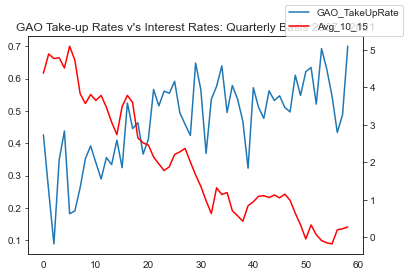

Correlation - Quarterly =  -0.76


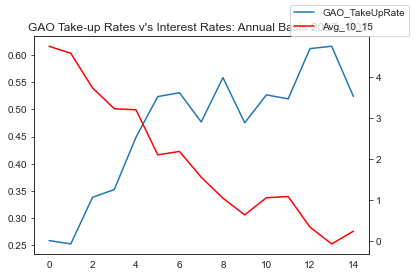

Correlation - Annual =  -0.92


In [14]:
# Visualising relationship between Interest Rates and GAO Take-up Rates both Quarterly and Yearly bases at Aggregate level

# Conclusion: 

# GAO Take-up Rates:  while displaying some volatility the overall tread has been upwards 
#                     from approx. 25% in 2027 to over 60% in 2020 with 2021 falling back to just over 50%.


# Interesdt Rate / GAO take-up Rate Relationship

#               Strong negative relationship from graphs and correlation co-efficients
                # Annual data has higher correlation of -0.92
                # Quarterly data also shows inverse relationship but is more noisy and has lower correlation co-efficient of -0.76 

# Quarterly Basis
df1_CQ=df1.groupby(['Contract_Quarter']).agg({'Exposure':sum,'Claim':sum, 'Avg_10_15': np.average, 'AvgC_10_15':np.average}).copy()
df1_CQ['GAO_TakeUpRate'] = df1_CQ['Claim']/df1_CQ['Exposure']
df1_CQ.reset_index(inplace=True)
#print(df1_CQ[['Contract_Quarter', 'GAO_TakeUpRate']])

# Annual Basis
df1_CY=df1.groupby(['Contract_Year']).agg({'Exposure':sum,'Claim':sum, 'Avg_10_15': np.average, 'AvgC_10_15':np.average}).copy()
df1_CY['GAO_TakeUpRate'] = df1_CY['Claim']/df1_CY['Exposure']
df1_CY.reset_index(inplace=True)
print(df1_CY[['Contract_Year', 'GAO_TakeUpRate', 'Avg_10_15']])


# printing Quarterly Basis



sns.set_style("white")
ax = df1_CQ.plot.line(y=['GAO_TakeUpRate'], legend=False)
ax2 = ax.twinx()
df1_CQ.plot.line(y=['Avg_10_15'], ax=ax2, legend=False,color='r')
ax.figure.legend()
ax.set_title("GAO Take-up Rates v's Interest Rates: Quarterly Basis 2007 - 2021")
plt.show() 
print('Correlation - Quarterly = ', round(df1_CQ['GAO_TakeUpRate']. corr(df1_CQ['Avg_10_15']),2))

# printing Annual Basis

ax = df1_CY.plot.line(y=['GAO_TakeUpRate'], legend=False)
ax2 = ax.twinx()
df1_CY.plot.line(y=['Avg_10_15'], ax=ax2, legend=False,color='r')
ax.figure.legend()
ax.set_title("GAO Take-up Rates v's Interest Rates: Annual Basis 2007 - 2021")
plt.show() 
print('Correlation - Annual = ', round(df1_CY['GAO_TakeUpRate']. corr(df1_CY['Avg_10_15']),2))

OP_A
Correlation - Annual =  -0.39


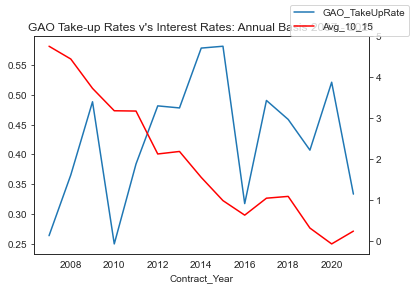

OP_B
Correlation - Annual =  -0.9


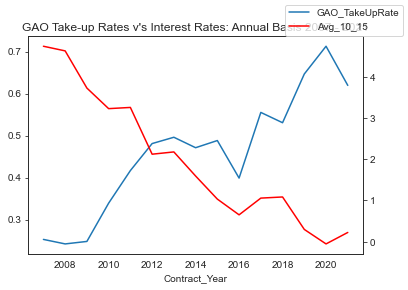

PP_B
Correlation - Annual =  -0.78


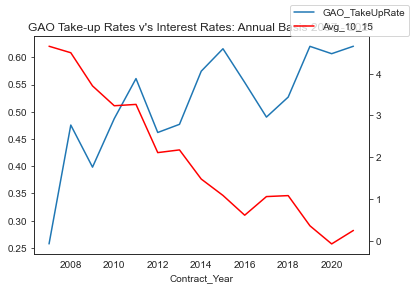

PP_A
Correlation - Annual =  -0.83


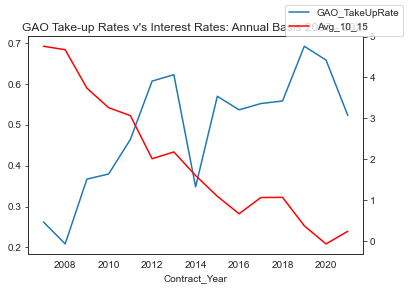

In [15]:
# Visualising relationship between Interest Rates and GAO Take-up Rates on annual basis at product level

# Conclusion: Similar strong negative relationship from graphs and correlation co-efficients across most products
                # with correlations as follows
                 #   Op_B = -0.90
                 #   PP_A = -0.83
                 #   PP_B = -0.73
                 #   OP_A = -0.39     
   


for i in range(df1['Product'].value_counts().shape[0]):
        
        print(df1['Product'].value_counts().index[i])         
        df1_grouping = df1[(df1['Product'] == df1['Product'].value_counts().index[i])].copy()  
        df1_grouping=df1_grouping.groupby(['Contract_Year']).agg({'Exposure':sum,'Claim':sum, 'Avg_10_15': np.average, 'AvgC_10_15':np.average}).copy()
        df1_grouping['GAO_TakeUpRate'] = df1_grouping['Claim']/df1_grouping['Exposure']        
        
        
        ax = df1_grouping.plot.line(y=['GAO_TakeUpRate'], legend=False)
        ax2 = ax.twinx()
        df1_grouping.plot.line(y=['Avg_10_15'], ax=ax2, legend=False,color='r')
        ax.figure.legend()
        ax.set_title("GAO Take-up Rates v's Interest Rates: Annual Basis 2007 - 2021")
        print('Correlation - Annual = ', round(df1_grouping['GAO_TakeUpRate']. corr(df1_grouping['Avg_10_15']),2))
        plt.show() 

In [16]:
# Model development for valuation of GAO Take-uo Rates for the remaining in-force portfolio

# Linear Regression Analyses

# Step 1

# Standard analysis routine to investigate the relationship between Interest Rates and GAO Take-up Rates for the selected data grouping consisting of 

# (i) checktotals on Exposure and Claims 
# (ii) line plots of GAO take-up Rate v's Interest Rates
# (iii) heatmap for correlation 
# (iv) Joint plot from Seaborn
# (v) Regression plot from seaborn
# (vi) Residuals Plot from seaborn
# (vii) model fitting and key output from statsmodels


def Analyses():
     
        print ("Exposure = ", round(df1_grouping["Exposure"].sum()/10**6,1),"Claim = ", round(df1_grouping["Claim"].sum()/10**6,1), "Shape =",df1_grouping.shape)
                 
        sns.set_style("white")
        ax= df1_grouping.plot.line(y=['GAO_TakeUpRate'], legend=False)
        ax2 = ax.twinx()
        df1_grouping.plot.line(y=['AvgC_10_15'], ax=ax2, legend=False,color='r')
        ax.figure.legend()
        ax.set_title("Euro Swap Rate v's GAO Take-up Rates")
        plt.show()

        sns.heatmap(df1_grouping.corr(),annot=True)
        plt.show()

        
        print("Joint Plot")
        sns.jointplot(data=df1_grouping, x='AvgC_10_15', y='GAO_TakeUpRate',kind='reg')
        plt.show()
        
        print("Regression Plot")
        sns.regplot(x='AvgC_10_15',y='GAO_TakeUpRate', data=df1_grouping)
        plt.show()

        print("Redisuals Plot")
        sns.residplot(x='AvgC_10_15',y='GAO_TakeUpRate', data=df1_grouping)
        plt.show()

        
        model_lin = sm.OLS.from_formula("GAO_TakeUpRate ~ AvgC_10_15", data=df1_grouping)
        result_lin = model_lin.fit()
        print( 'Intercept and Slope =', result_lin.params, 'R Squared = ', round(result_lin.rsquared, 4))
        print(result_lin.summary())

Exposure =  147.2 Claim =  68.5 Shape = (20, 5)


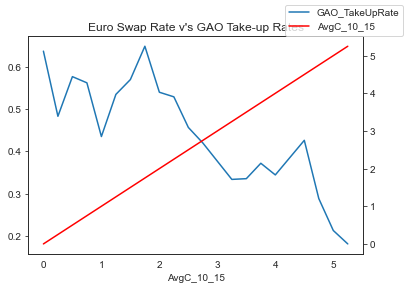

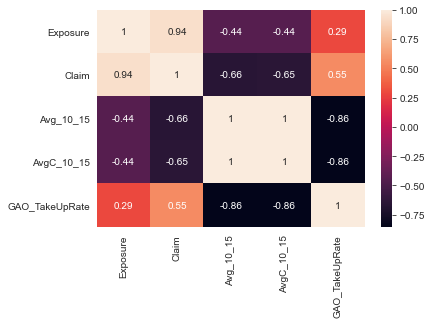

Joint Plot


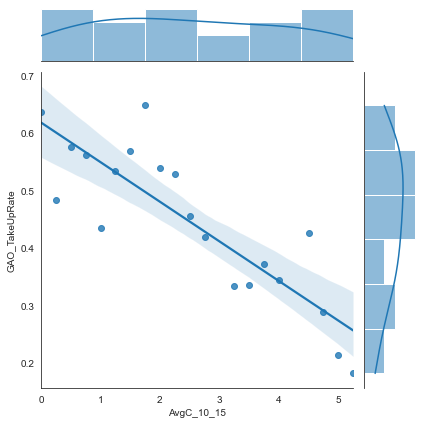

Regression Plot


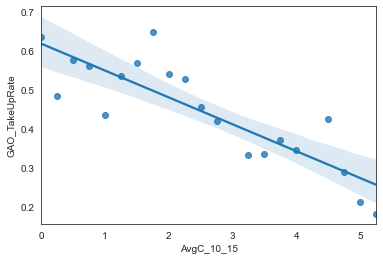

Redisuals Plot


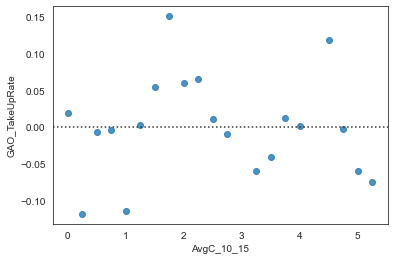

Intercept and Slope = Intercept     0.618134
AvgC_10_15   -0.068865
dtype: float64 R Squared =  0.7346
                            OLS Regression Results                            
Dep. Variable:         GAO_TakeUpRate   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     49.83
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           1.39e-06
Time:                        09:19:20   Log-Likelihood:                 25.691
No. Observations:                  20   AIC:                            -47.38
Df Residuals:                      18   BIC:                            -45.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [17]:
#  Aggregate Model grouped by Interest rate bands: Testing relationship between Interest rates and GAO Take-Up Rates on data grouped by Interest Rate bands

#  Conclusion: better evidence of negative linear relationship than from Claim level model 
        # (i) visually from lineplot and lmplot
        # (ii) correlation of -0.86 (Claim level model: 0.10)
        # R Squared from linear regression model is high at 0.735  (Claim Level model: 0.01)
         
      

df1_IntRateBands=df1.groupby(['AvgC_10_15',]).agg({'Exposure':sum,'Claim':sum, 'Avg_10_15': np.average, 'AvgC_10_15':np.average}).copy()
df1_IntRateBands['GAO_TakeUpRate'] = df1_IntRateBands['Claim']/df1_IntRateBands['Exposure']

df1_grouping=df1_IntRateBands.copy()

Analyses()

Exposure =  119.1 Claim =  55.9 Shape = (20, 5)


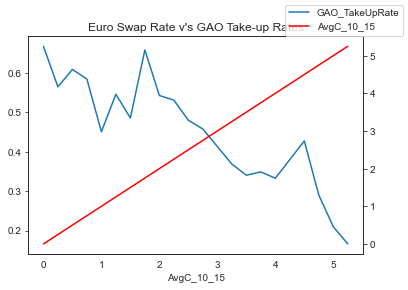

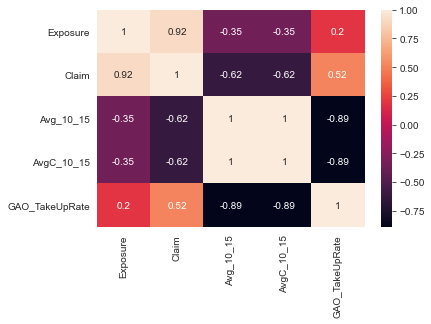

Joint Plot


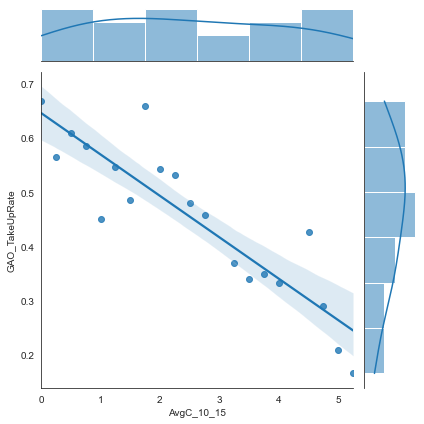

Regression Plot


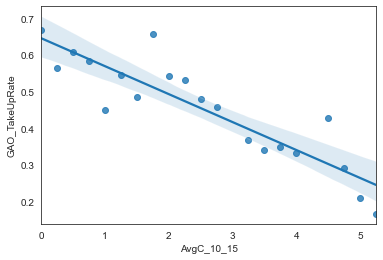

Redisuals Plot


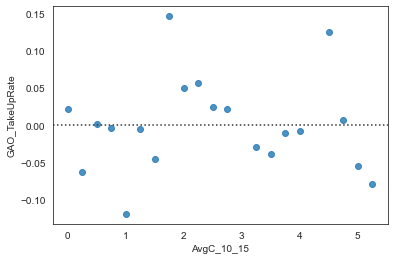

Intercept and Slope = Intercept     0.646183
AvgC_10_15   -0.076356
dtype: float64 R Squared =  0.8002
                            OLS Regression Results                            
Dep. Variable:         GAO_TakeUpRate   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     72.07
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           1.04e-07
Time:                        09:19:21   Log-Likelihood:                 27.316
No. Observations:                  20   AIC:                            -50.63
Df Residuals:                      18   BIC:                            -48.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [18]:
# testing for grouping PP_A + PP_B + OP_B combined 

# Because OP_B product is targeted at professionals in occupational schemes and may tend to have similar charteristisc as personal pensions policies
# i.e. more financially aware of the value of the GAO

df1_grouping=df1[(df1['Product'] !="OP_A")].copy()
             

df1_grouping=df1_grouping.groupby(['AvgC_10_15',]).agg({'Exposure':sum,'Claim':sum, 'Avg_10_15': np.average, 'AvgC_10_15':np.average}).copy()
df1_grouping['GAO_TakeUpRate'] = df1_grouping['Claim']/df1_grouping['Exposure']
          
Analyses()

    Contract_Year  GAO_TakeUpRate
0            2007        0.263925
1            2008        0.365632
2            2009        0.488324
3            2010        0.250124
4            2011        0.384064
5            2012        0.481437
6            2013        0.477989
7            2014        0.578268
8            2015        0.581358
9            2016        0.317708
10           2017        0.490527
11           2018        0.458726
12           2019        0.407294
13           2020        0.521059
14           2021        0.333579
    Contract_Year      Exposure         Claim  GAO_TakeUpRate
10           2017  2.067673e+06  1.014250e+06        0.490527
11           2018  1.655046e+06  7.592133e+05        0.458726
12           2019  2.150657e+06  8.759494e+05        0.407294
13           2020  2.408483e+06  1.254962e+06        0.521059
Exposure =  28.1 Claim =  12.7 Shape = (15, 6)


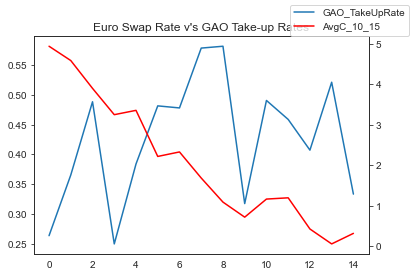

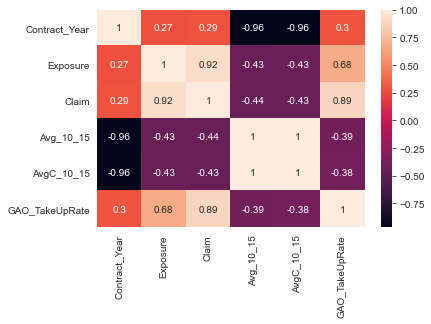

Joint Plot


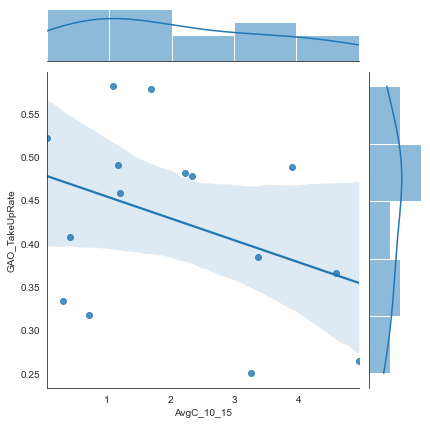

Regression Plot


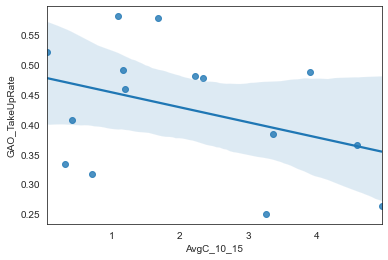

Redisuals Plot


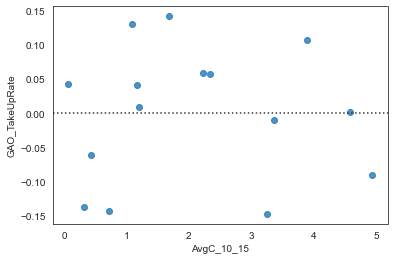

Intercept and Slope = Intercept     0.479270
AvgC_10_15   -0.025247
dtype: float64 R Squared =  0.1459
                            OLS Regression Results                            
Dep. Variable:         GAO_TakeUpRate   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     2.220
Date:                Tue, 23 Nov 2021   Prob (F-statistic):              0.160
Time:                        09:19:24   Log-Likelihood:                 14.217
No. Observations:                  15   AIC:                            -24.43
Df Residuals:                      13   BIC:                            -23.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [19]:
# non-regression approach for OP_A

# this product has lowers r Square from the analysis if the 4 products at 0.176
# which suggests no strong relationship
#  This could reflect the target market of unskilled, low skilled employees who have smaller pensions and may not be  financially sophisticated 

#so. a better basis for setting GAO take up rate assumptions might be a simple average of past years
# note that GAO take-up Rate for 2021 year is unusually low at 33 relative to previous 4 years
# Therefore use average over 2017-2020 period
# This average GAO Take-up Rate is 0.471

df1_OP_A = df1[(df1['Product'] == 'OP_A')]  
df1_OP_A=df1_OP_A.groupby(['Contract_Year',]).agg({'Exposure':sum,'Claim':sum, 'Avg_10_15': np.average, 'AvgC_10_15':np.average}).copy()
df1_OP_A['GAO_TakeUpRate'] = df1_OP_A['Claim']/df1_OP_A['Exposure']
df1_OP_A.reset_index(inplace=True)
print(df1_OP_A[['Contract_Year', 'GAO_TakeUpRate']])




df1_OP_A_Avg = df1_OP_A[(df1_OP_A['Contract_Year'] > 2016) & (df1_OP_A['Contract_Year'] != 2021)] 
print(df1_OP_A_Avg[['Contract_Year', 'Exposure', 'Claim', 'GAO_TakeUpRate']])


df1_grouping=df1_OP_A.copy()

Analyses()

e=round(df1_OP_A_Avg['Exposure'].sum()/10**6,3)
c=round(df1_OP_A_Avg['Claim'].sum()/10**6,3)
r=round(c/e,3)
print("Avg GAO Take-up Rate for 2017-2020 = ", r, 'Exposure = ', e, 'Claims = ', c )



In [20]:
# The remaining analyses were used to investigate whether other groupings analysed both on simple linear regression and multiple regression basis produced a better model

# The main elements were
# (i) regression analysis at individual Claim level 
# (ii) analysis at individual product level (other than PP_A+ PPB+  OP_B combined) using simple linear analysis
# (iii) multiple linear analyses using products as additional regressors.

# Conclusion: None of these produced a better model


Exposure =  147.2 Claim =  68.5 Shape = (4156, 10)


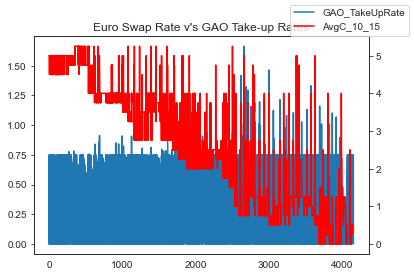

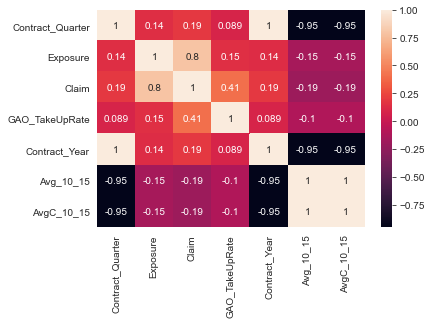

Joint Plot


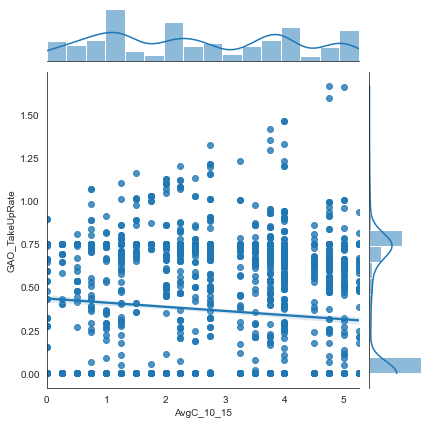

Regression Plot


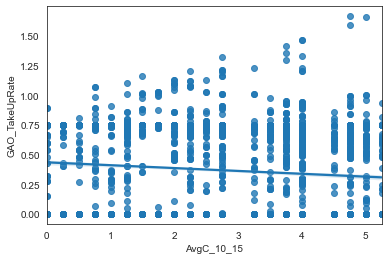

Redisuals Plot


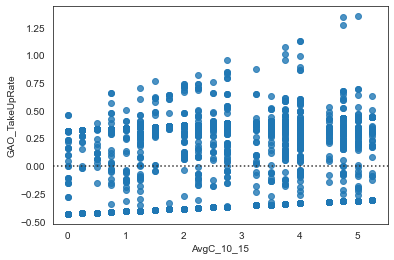

Intercept and Slope = Intercept     0.434325
AvgC_10_15   -0.024102
dtype: float64 R Squared =  0.0104
                            OLS Regression Results                            
Dep. Variable:         GAO_TakeUpRate   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     43.70
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           4.31e-11
Time:                        09:19:27   Log-Likelihood:                -1705.4
No. Observations:                4154   AIC:                             3415.
Df Residuals:                    4152   BIC:                             3427.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [21]:
#  Individual Claim Level model: Testing relationship between Interest rates and GAO Take-Up Rates at individual claim level

# Conclusion:  
# (i) weak evidence of inverse relationship with correlation from heat map of regression = -0.10
# (ii) Rsquared is very low as just 0.01
# (iii) from the scatter plot individual claims have a large proportion of GAO take-up rates at either 0% (i.e. did not take GAO) or 75% (max GAO take-up rate)
# and not many cases in between
# (iv) Overall conclusion is that claim level data is too noisy to reveal any strong relationship between interest rates and GAO take-up rates.


df1_grouping=df1.copy()

Analyses()

OP_A
Exposure =  28.1 Claim =  12.7 Shape = (20, 5)


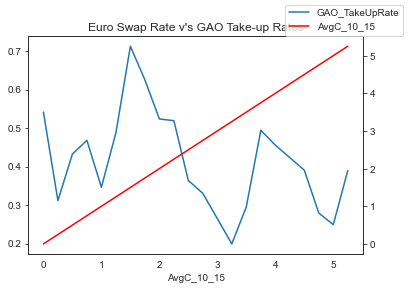

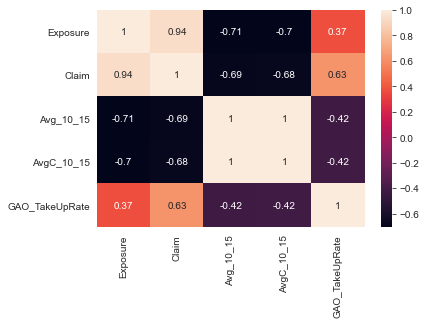

Joint Plot


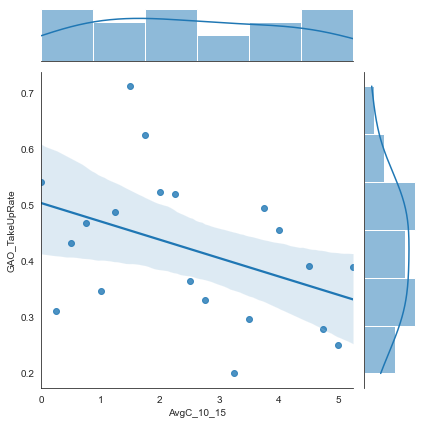

Regression Plot


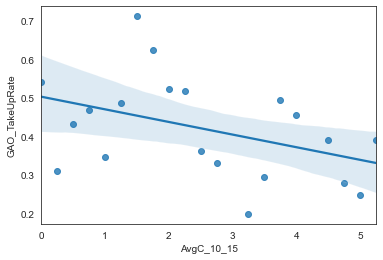

Redisuals Plot


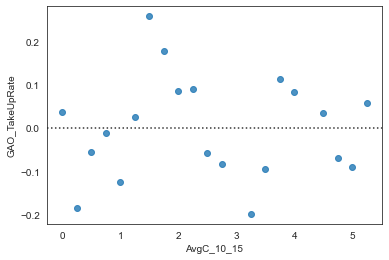

Intercept and Slope = Intercept     0.503436
AvgC_10_15   -0.032796
dtype: float64 R Squared =  0.1759
                            OLS Regression Results                            
Dep. Variable:         GAO_TakeUpRate   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     3.842
Date:                Tue, 23 Nov 2021   Prob (F-statistic):             0.0657
Time:                        09:19:29   Log-Likelihood:                 14.901
No. Observations:                  20   AIC:                            -25.80
Df Residuals:                      18   BIC:                            -23.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

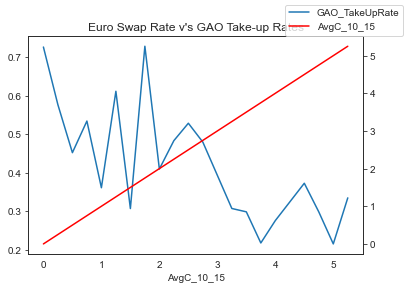

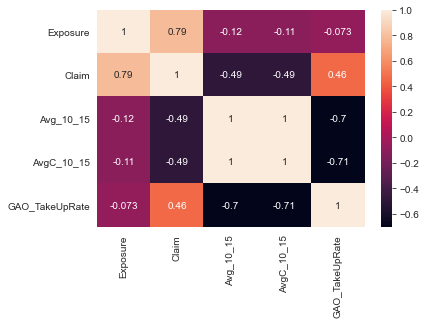

Joint Plot


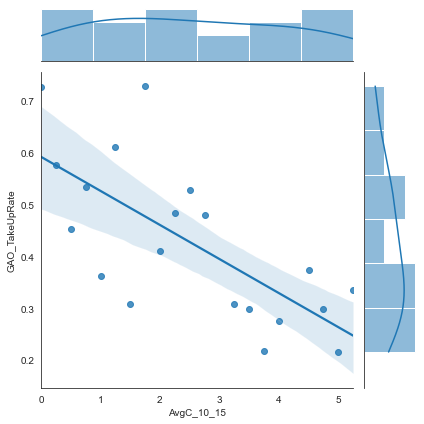

Regression Plot


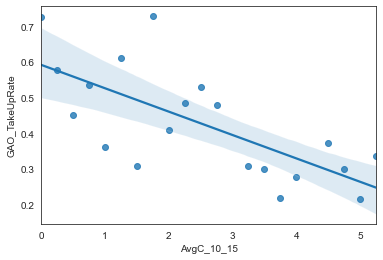

Redisuals Plot


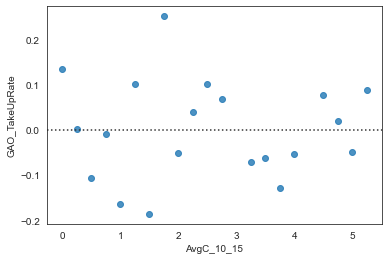

Intercept and Slope = Intercept     0.592083
AvgC_10_15   -0.065660
dtype: float64 R Squared =  0.4971
                            OLS Regression Results                            
Dep. Variable:         GAO_TakeUpRate   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     17.79
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           0.000517
Time:                        09:19:30   Log-Likelihood:                 16.346
No. Observations:                  20   AIC:                            -28.69
Df Residuals:                      18   BIC:                            -26.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

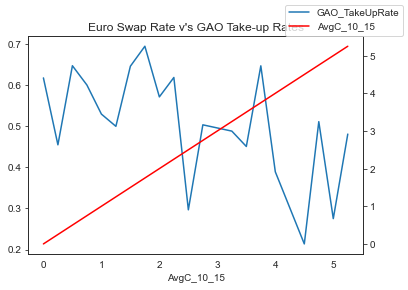

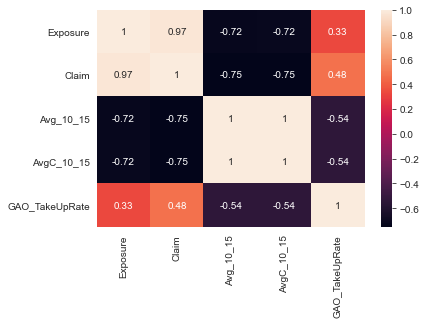

Joint Plot


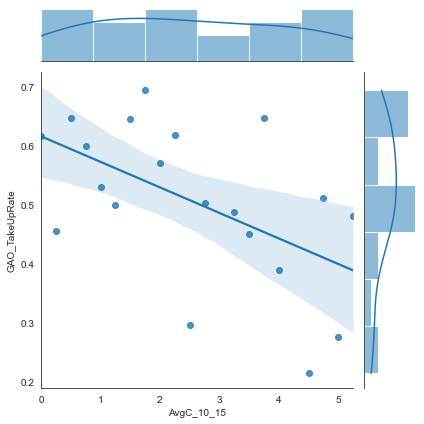

Regression Plot


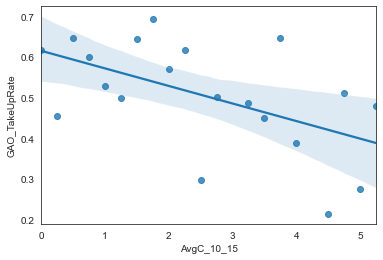

Redisuals Plot


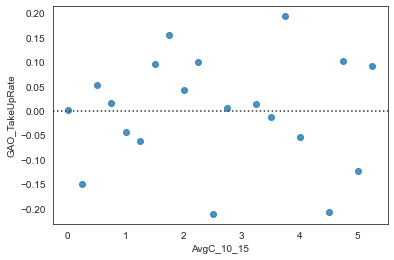

Intercept and Slope = Intercept     0.615599
AvgC_10_15   -0.043271
dtype: float64 R Squared =  0.292
                            OLS Regression Results                            
Dep. Variable:         GAO_TakeUpRate   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     7.423
Date:                Tue, 23 Nov 2021   Prob (F-statistic):             0.0139
Time:                        09:19:32   Log-Likelihood:                 15.945
No. Observations:                  20   AIC:                            -27.89
Df Residuals:                      18   BIC:                            -25.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

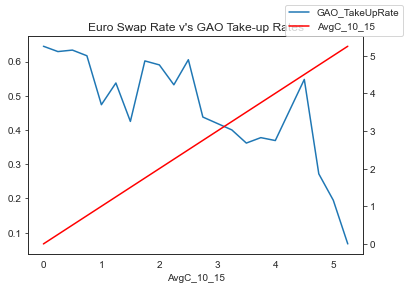

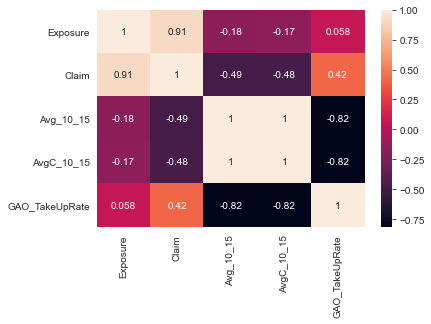

Joint Plot


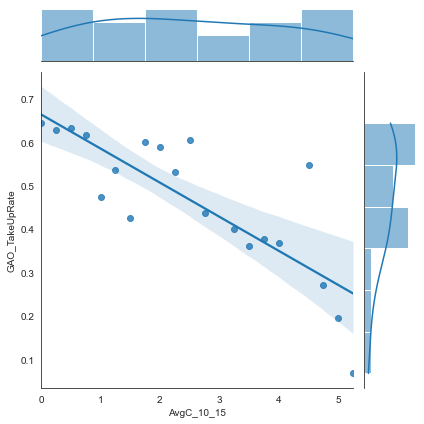

Regression Plot


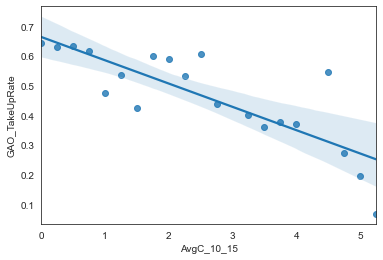

Redisuals Plot


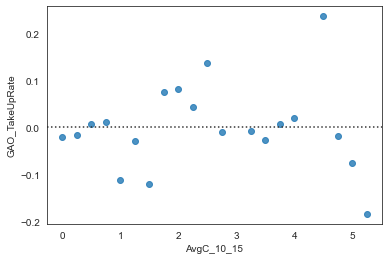

Intercept and Slope = Intercept     0.664484
AvgC_10_15   -0.078624
dtype: float64 R Squared =  0.669
                            OLS Regression Results                            
Dep. Variable:         GAO_TakeUpRate   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     36.38
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           1.06e-05
Time:                        09:19:35   Log-Likelihood:                 19.896
No. Observations:                  20   AIC:                            -35.79
Df Residuals:                      18   BIC:                            -33.80
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [22]:
# Individual Product Models
#  Testing to see if regression model can be improved by investigating the relationship between Interest rates and GAO Take-Up Rates at product level

#  Conclusion: 
        # (i) PP_A performs best with correlation co-efficient of 0.82 and r square of 0.669
        # (ii) other products show weaker negative correaltion and lower r squares than PP_A
         
# None of these groupings are better than the combined PP_A+PP_B+ OP_B mondel which has an rR square = 0.80


# Script below to loop through data gathering and analyses of each of the 4 Products

for i in range(df1['Product'].value_counts().shape[0]):
        
        print(df1['Product'].value_counts().index[i])         
        df1_grouping = df1[(df1['Product'] == df1['Product'].value_counts().index[i])].copy()  
        df1_grouping=df1_grouping.groupby(['AvgC_10_15',]).agg({'Exposure':sum,'Claim':sum, 'Avg_10_15': np.average, 'AvgC_10_15':np.average}).copy()
        df1_grouping['GAO_TakeUpRate'] = df1_grouping['Claim']/df1_grouping['Exposure']
          
        Analyses()


In [23]:
# Multiple Regression analyses

# Testing to see if improved model can be achieved using multiple regression by adding in each Product as an additional regressor

# Run multiple regression with each of the 4 products as additional regressors
# Conclusion: R square = 0.433 when the 4 individual groups are uses 
               # and r square of 0.395 when the grouping of PP_A+ PPB_+OP_A is included 
                # both of which are much lower than earlier aggregate model which had r square = 0.735

# No benefit from using multiple regression using products compared to Aggregate Model


# Step 1:  build appropriate dataframe
# Group by Product and Interest rate bands

df1_Product_IntRateBands=df1.groupby(['Product','AvgC_10_15',],as_index=False).agg({'Exposure':sum,'Claim':sum, 'Avg_10_15': np.average, 'AvgC_10_15':np.average}).copy()

# make another dataframe with dummy variables for the Products for the regression

df1_Product_IntRateBands_D=pd.get_dummies(df1_Product_IntRateBands, columns=['Product']).copy()

# aslo create a Product column for PP_A + PP_B + OP_B

df1_Product_IntRateBands_D['Product_PP_All_OP_B'] = df1_Product_IntRateBands_D['Product_PP_A']+ df1_Product_IntRateBands_D['Product_PP_B']+df1_Product_IntRateBands_D['Product_OP_B']

# calculate GAO_Take_UPRates  for all rows
df1_Product_IntRateBands_D['GAO_TakeUpRate'] = df1_Product_IntRateBands_D['Claim']/df1_Product_IntRateBands_D['Exposure']



df1_grouping=df1_Product_IntRateBands_D.copy()

 # Analyses()

model_lin = sm.OLS.from_formula("GAO_TakeUpRate ~ AvgC_10_15 + Product_OP_A +Product_OP_B+ Product_PP_A+ Product_PP_B", data=df1_grouping)
result_lin = model_lin.fit()
print( 'Intercept and Slope =', result_lin.params, 'R Squared = ', round(result_lin.rsquared, 4))
print(result_lin.summary())

model_lin = sm.OLS.from_formula("GAO_TakeUpRate ~ AvgC_10_15+Product_PP_All_OP_B", data=df1_grouping)
result_lin = model_lin.fit()
print( 'Intercept and Slope =', result_lin.params, 'R Squared = ', round(result_lin.rsquared, 4))
print(result_lin.summary())

Intercept and Slope = Intercept       0.475121
AvgC_10_15     -0.055088
Product_OP_A    0.084602
Product_OP_B    0.090268
Product_PP_A    0.129933
Product_PP_B    0.170317
dtype: float64 R Squared =  0.4327
                            OLS Regression Results                            
Dep. Variable:         GAO_TakeUpRate   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     14.30
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           1.01e-08
Time:                        09:19:35   Log-Likelihood:                 63.468
No. Observations:                  80   AIC:                            -116.9
Df Residuals:                      75   BIC:                            -105.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
   

In [ ]:
# The remaining code exports various graphs for importing into the Project Report 

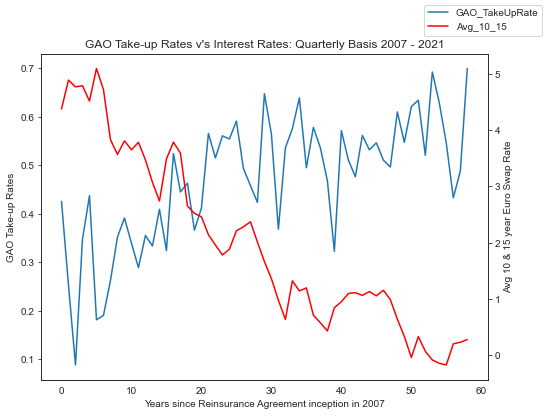

In [45]:
# printing Quarterly Basis

sns.set_style("white")

fig_dims = (8,6)
fig, ax = plt.subplots(figsize=fig_dims)

ax = df1_CQ.plot.line(y=['GAO_TakeUpRate'],ax=ax, legend=False)
ax2 = ax.twinx()
df1_CQ.plot.line(y=['Avg_10_15'], ax=ax2, legend=False,color='r')
ax.figure.legend()
ax.set_title("GAO Take-up Rates v's Interest Rates: Quarterly Basis 2007 - 2021")
ax.set(xlabel="Years since Reinsurance Agreement inception in 2007")
ax.set(ylabel="GAO Take-up Rates")
ax2.set(ylabel="Avg 10 & 15 year Euro Swap Rate")


plt.savefig('C:\A_Treasure\\UCD course 2021\Assignment\QGAOIntRates_conf.png', dpi=400)

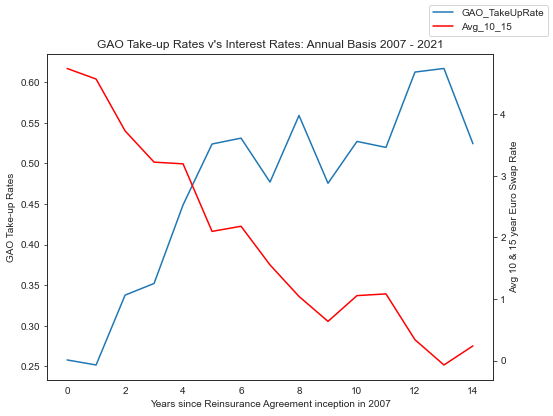

In [44]:
# printing Annual Basis
sns.set_style("white")
fig_dims = (8,6)
fig, ax = plt.subplots(figsize=fig_dims)

ax = df1_CY.plot.line(y=['GAO_TakeUpRate'], ax=ax, legend=False)
ax2 = ax.twinx()
df1_CY.plot.line(y=['Avg_10_15'], ax=ax2, legend=False,color='r')
ax.figure.legend()
ax.set_title("GAO Take-up Rates v's Interest Rates: Annual Basis 2007 - 2021")
ax.set(xlabel="Years since Reinsurance Agreement inception in 2007")
ax.set(ylabel="GAO Take-up Rates")
ax2.set(ylabel="Avg 10 & 15 year Euro Swap Rate")

plt.savefig('C:\A_Treasure\\UCD course 2021\Assignment\YGAOIntRates_conf.png', dpi=400)

In [ ]:
# Saving interest Rate Graph


sns.set_style("whitegrid")
g= sns.lineplot(x=df_R3['DateOfRate'], y=df_R3['Avg_10_15'])
g.set_title("Euro Swap Rate (agv(10Y,15Y): 2007 - 2021")
plt.show()

plt.savefig('C:\A_Treasure\\UCD course 2021\Assignment\g_conf.png', dpi=400)


Joint Plot
Regression Plot
Redisuals Plot


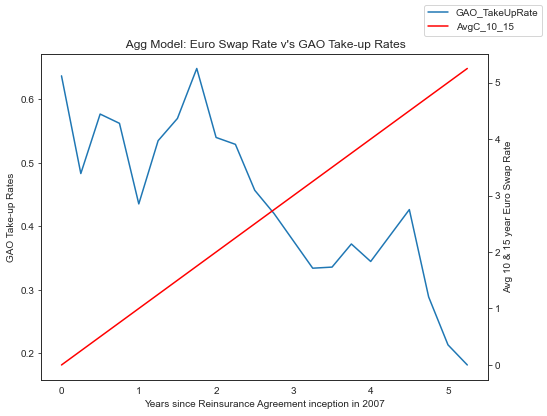

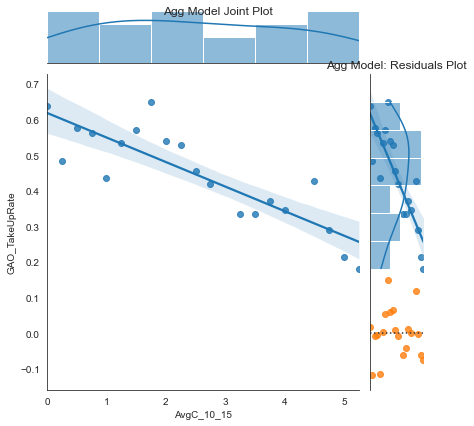

In [51]:
# saving graphs from Aggregate Model


sns.set_style("white")
fig_dims = (8,6)
fig, ax = plt.subplots(figsize=fig_dims)


ax= df1_IntRateBands.plot.line(y=['GAO_TakeUpRate'], ax=ax, legend=False)
ax2 = ax.twinx()
df1_IntRateBands.plot.line(y=['AvgC_10_15'], ax=ax2, legend=False,color='r')
ax.figure.legend()
ax.set_title(" Agg Model: Euro Swap Rate v's GAO Take-up Rates")

ax.set(xlabel="Years since Reinsurance Agreement inception in 2007")
ax.set(ylabel="GAO Take-up Rates")
ax2.set(ylabel="Avg 10 & 15 year Euro Swap Rate")

plt.savefig('C:\A_Treasure\\UCD course 2021\Assignment\AggGAOIntRates_conf.png', dpi=400)
        
 
print("Joint Plot")
g=sns.jointplot(data=df1_IntRateBands, x='AvgC_10_15', y='GAO_TakeUpRate',kind='reg')
#g.set_title
g.fig.suptitle("Agg Model Joint Plot")

plt.savefig('C:\A_Treasure\\UCD course 2021\Assignment\AggJointPlot_conf.png', dpi=400)  

Redisuals Plot


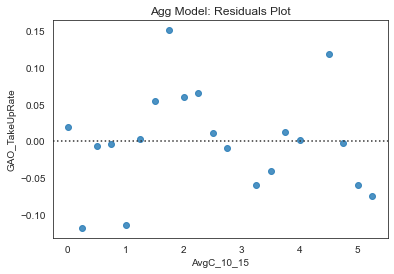

In [52]:
# saving graphs from Aggregate Model

print("Redisuals Plot")
g= sns.residplot(x='AvgC_10_15',y='GAO_TakeUpRate', data=df1_IntRateBands)
#g.fig.suptitle("Agg Model: Residuals Plot")
g.set_title("Agg Model: Residuals Plot")

plt.savefig('C:\A_Treasure\\UCD course 2021\Assignment\AggResiduals_conf.png', dpi=400)


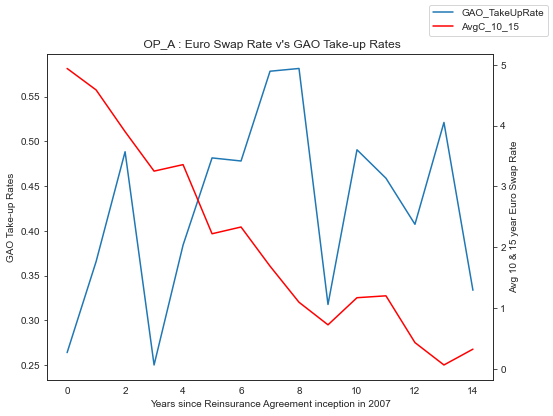

In [58]:
# saving graphs from OP_A

sns.set_style("white")
fig_dims = (8,6)
fig, ax = plt.subplots(figsize=fig_dims)


ax= df1_OP_A.plot.line(y=['GAO_TakeUpRate'], ax=ax, legend=False)
ax2 = ax.twinx()
df1_OP_A.plot.line(y=['AvgC_10_15'], ax=ax2, legend=False,color='r')
ax.figure.legend()
ax.set_title(" OP_A : Euro Swap Rate v's GAO Take-up Rates")

ax.set(xlabel="Years since Reinsurance Agreement inception in 2007")
ax.set(ylabel="GAO Take-up Rates")
ax2.set(ylabel="Avg 10 & 15 year Euro Swap Rate")

plt.savefig('C:\A_Treasure\\UCD course 2021\Assignment\OPAGAOIntRates_conf.png', dpi=400)


Redisuals Plot


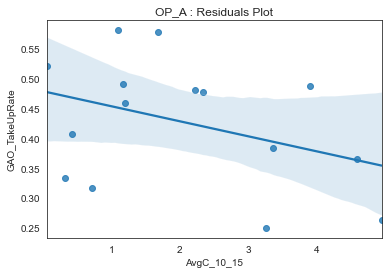

In [57]:
#regplot from OP_A

print("Redisuals Plot")
g= sns.regplot(x='AvgC_10_15',y='GAO_TakeUpRate', data=df1_OP_A)
#g.fig.suptitle("Agg Model: Residuals Plot")
g.set_title("OP_A : Residuals Plot")

plt.savefig('C:\A_Treasure\\UCD course 2021\Assignment\OPARegPlot_conf.png', dpi=400)


In [61]:
# exporting QP_A table of GAO Rates to Excel
dfOP =df1_OP_A[['Contract_Year', 'GAO_TakeUpRate']]
dfOP

dfOP.to_excel(r'C:\A_Treasure\\UCD course 2021\Assignment\df1_output.xlsx', sheet_name='Sheet1')